In [1]:
import random
import time
import json
import tabula
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from selenium import webdriver
from sklearn.neighbors import KernelDensity
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains

In [44]:
def results2by2(name1, name2, driver):
    wait = WebDriverWait(driver, 5)    # Espera a que el botón esté visible o pasen 5 segundos
    
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARROW_DOWN)
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARROW_DOWN)
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARROW_DOWN)
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARROW_DOWN)
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARROW_DOWN)
    driver.find_element(By.TAG_NAME, "body").send_keys(Keys.ARROW_DOWN)

    playerA = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[type="text"][name="auto-complete234"]')))
    playerA.clear()
    playerA.send_keys(name1)
    
    time.sleep(3)
    
    element1 = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, "(//ul[@class='dropdown-menu'])/li[1]")))
    a_element = element1.find_element(By.TAG_NAME, "a")
    a_element.click()
    
    playerB = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[type="text"][name="auto-complete236"]')))
    playerB.clear()
    playerB.send_keys(name2)
    
    time.sleep(3)
    
    element2 = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.XPATH, "(//ul[@class='dropdown-menu'])[2]/li[1]")))
    b_element = element2.find_element(By.TAG_NAME, "a")
    b_element.click()
    

    button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='filter']")))
    button.click()
    
    table = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "table.table.table-striped.table-condensed.table-sm")))
    rows = table.find_elements(By.XPATH, ".//tbody/tr")
    
    results = []
    for i in range(1, len(rows)):
        cells = rows[i].find_elements(By.XPATH, ".//td")
        year = cells[0].text
        result = cells[9].text[0] + cells[9].text[4]
        results.append((year, result))
        
    return results

In [45]:
def scraping_names(modalidad):
    # Hay que hacer la seleccion de los jugadores real, esto es ilustrativo
    
    driver = webdriver.Chrome()    # Inicio el navegador 
    wait = WebDriverWait(driver, 10)    # Espera a que el botón esté visible o pasen 10 segundos

    driver.get('https://www.ittf.com/wp-content/uploads/2024/05/2024_22_SEN_MS-1.html')    # Me dirijo a la pagina correspondiente
    
    table = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "table")))
    rows = table.find_elements(By.XPATH, ".//tbody/tr[contains(@class, 'rrow')]")
    
    results = []
    i = 0
    while(len(results) != 70):
        cells = rows[i].find_elements(By.XPATH, ".//td")
        name = cells[1].text
        country_code = cells[2].text
        results.append(name)
        i += 1
        
    # Guarda los resultados en un archivo JSON
    with open(f'{modalidad}.json', 'w') as f:
        json.dump(results, f)
    
    return results
    

In [46]:
def scraping_names_from_pdf():
    # Lee el archivo PDF como un DataFrame de pandas
    dfM = pd.read_excel("Men26Jun.xlsx")
    dfW = pd.read_excel("Women26Jun.xlsx")
    
    # Guarda en singleMen todas las filas que tengan una 'x' en la columna Singles
    # y de cada fila solo guarda lo que esta en la columna Athlete (el nombre)
    singleMen = dfM[dfM['SINGLES'] == 'x']['ATHLETE'].tolist()
    with open('singleMen.json', 'w') as f:
        json.dump(singleMen, f)
    
    # Guarda en teamsMen todas las filas que tengan una 'x' en la columna Teams
    # y de cada fila solo guarda lo que esta en la columna Athlete (el nombre)
    teamsMen = dfM[dfM['TEAMS'] == 'x']['ATHLETE'].tolist()
    with open('teamsMen.json', 'w') as f:
        json.dump(teamsMen, f)
    
    # Guarda en singleWomen todas las filas que tengan una 'x' en la columna Singles
    # y de cada fila solo guarda lo que esta en la columna Athlete (el nombre)
    singleWomen = dfW[dfW['SINGLES'] == 'x']['ATHLETE'].tolist()
    with open('singleWomen.json', 'w') as f:
        json.dump(singleWomen, f)
    
    # Guarda en teamsWomen todas las filas que tengan una 'x' en la columna Teams
    # y de cada fila solo guarda lo que esta en la columna Athlete (el nombre)
    teamsWomen = dfW[dfW['TEAMS'] == 'x']['ATHLETE'].tolist()
    with open('teamsWomen.json', 'w') as f:
        json.dump(teamsWomen, f)
    
    # Guarda en mixed todas las filas que tengan una 'x' en la columna Mixed doubles
    # y de cada fila solo guarda lo que esta en la columna Athlete (el nombre)
    mixedW = dfW[dfW['MIXED DOUBLES'] == 'x']['ATHLETE'].tolist()
    mixedM = dfM[dfM['MIXED DOUBLES'] == 'x']['ATHLETE'].tolist()
    
    mixed = mixedM + mixedW   
    with open('mixed.json', 'w') as f:
        json.dump(mixed, f)
    

In [47]:
scraping_names_from_pdf()

In [48]:
def pronostico(datos):
    original_lista = [40, 41, 42, 43, 34, 24, 14, 4]
    mapeada_lista = [1, 2, 3, 4, 5, 6, 7, 8]

    # Crear un diccionario de mapeo
    mapeo = dict(zip(original_lista, mapeada_lista))

    # Mapear la lista original
    lista_resultante = [mapeo[num] for num in datos]


    # Datos de ejemplo
    data = np.array([mapeo[num] for num in lista_resultante]).reshape(-1, 1)

    # Crear el estimador de KDE
    kde = KernelDensity(bandwidth=1.0, kernel='gaussian')  # Puedes ajustar el ancho de banda y el tipo de kernel

    # Ajustar el KDE a los datos
    kde.fit(data)

    valor = round(kde.sample(1)[0][0])
    minimo = min(data)[0]
    maximo = max(data)[0]
    if valor < minimo:
        valor = minimo
    elif valor > maximo:
        valor = maximo
        
    return original_lista[valor - 1]

In [49]:
def scraping(modalidad):    # Scrapear los datos
    driver = webdriver.Chrome()    # Inicio el navegador 
    wait = WebDriverWait(driver, 10)    # Espera a que el botón esté visible o pasen 10 segundos

    driver.get('https://results.ittf.link/index.php')    # Me dirijo a la pagina correspondiente
    
    driver.maximize_window()    # Maximizar la ventana del navegador
    
    accept_cookies = wait.until(EC.presence_of_element_located((By.CLASS_NAME, 'jb-accept')))
    accept_cookies.click()
    
    username = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[type="text"][name="username"]')))
    username.send_keys('Selenium1')
    
    password = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[type="password"][name="password"]')))
    password.send_keys('Selenium1**')

    bottom_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "div.gotobottom")))
    bottom_button.click()
    
    time.sleep(2)

    continue_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[name='Submit']")))
    continue_button.click()    # Haz clic en el botón "Log in"
    
    link = wait.until(EC.element_to_be_clickable((By.XPATH, '//a[@href="/index.php/head-to-head/list/26"]')))
    link.click()    
    
    button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='filter']")))
    button.click()
    
    
    
    name1 = 'WANG Chuqin'
    
    return
    names = []
    with open('singleMen', 'r') as f:
        names = json.load(f)
    
    playerA = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'input[type="text"][name="auto-complete234"]')))
    playerA.click()
    playerA.clear()
    playerA.send_keys(name1)
    
    button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='filter']")))
    button.click()
    
    diccionario = {}
    
    N = 2000
    for i in range(36, len(names)):
        for j in range(i+1, len(names)):
            if (j == i + 1 and not i == 22):
                # Nombre del archivo JSON
                nombre_archivo = "data.json"
                # Guardar el diccionario convertido en el archivo JSON
                with open(nombre_archivo, "w") as archivo_json:
                    json.dump(diccionario, archivo_json, indent=4)
                print(i)
            results = results2by2(names[i], names[j], driver)
            reversed_results = [(t[0], t[1][::-1]) for t in results]
            clave = str(names[i]) + ", " + str(names[j])
            clave_reverse = str(names[j]) + ", " + str(names[i])
            diccionario[clave] = [t[1] * (int(t[0]) - N) for t in results]
            diccionario[clave_reverse] = [t[1] * (int(t[0]) - N) for t in reversed_results]
    
    
    driver.quit()    # Cierro el navegador

    
    # Nombre del archivo JSON
    nombre_archivo = "data.json"

    # Guardar el diccionario convertido en el archivo JSON
    with open(nombre_archivo, "w") as archivo_json:
        json.dump(diccionario, archivo_json, indent=4)


# button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button.eb-close.placement-inside")))
# button.click()

# <input type="button" class="col-auto  btn-info btn fabrik_filter_submit button" value="Go" name="filter">


In [51]:
#Testeando la funcion de scraping

scraping(1)

# scraping_names(1)



The chromedriver version (124.0.6367.91) detected in PATH at C:\Users\Dani\Downloads\chromedriver-win64\chromedriver.exe might not be compatible with the detected chrome version (126.0.6478.127); currently, chromedriver 126.0.6478.126 is recommended for chrome 126.*, so it is advised to delete the driver in PATH and retry


SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 124
Current browser version is 126.0.6478.127 with binary path C:\Program Files\Google\Chrome\Application\chrome.exe
Stacktrace:
	GetHandleVerifier [0x00007FF7CDA31502+60802]
	(No symbol) [0x00007FF7CD9AAC02]
	(No symbol) [0x00007FF7CD867CE4]
	(No symbol) [0x00007FF7CD8A5942]
	(No symbol) [0x00007FF7CD8A4B42]
	(No symbol) [0x00007FF7CD89F8D3]
	(No symbol) [0x00007FF7CD89AA64]
	(No symbol) [0x00007FF7CD8E6037]
	(No symbol) [0x00007FF7CD8E56B0]
	(No symbol) [0x00007FF7CD8DA923]
	(No symbol) [0x00007FF7CD8A8FEC]
	(No symbol) [0x00007FF7CD8A9C21]
	GetHandleVerifier [0x00007FF7CDD3411D+3217821]
	GetHandleVerifier [0x00007FF7CDD760B7+3488055]
	GetHandleVerifier [0x00007FF7CDD6F03F+3459263]
	GetHandleVerifier [0x00007FF7CDAEB846+823494]
	(No symbol) [0x00007FF7CD9B5F9F]
	(No symbol) [0x00007FF7CD9B0EC4]
	(No symbol) [0x00007FF7CD9B1052]
	(No symbol) [0x00007FF7CD9A18A4]
	BaseThreadInitThunk [0x00007FFF1726257D+29]
	RtlUserThreadStart [0x00007FFF17F4AF28+40]


5
34

4


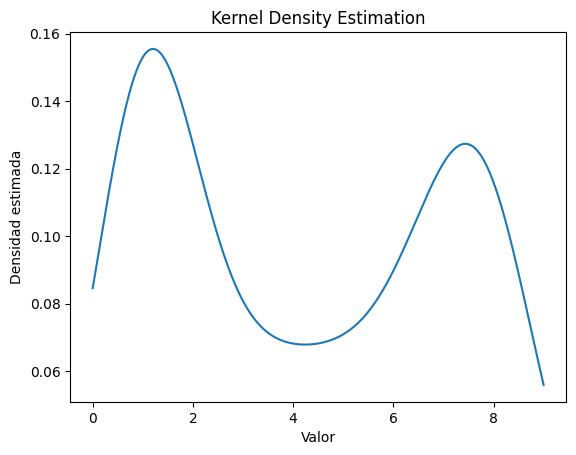

In [90]:
original_lista = [40, 41, 42, 43, 34, 24, 14, 4]
mapeada_lista = [1, 2, 3, 4, 5, 6, 7, 8]

# Crear un diccionario de mapeo
mapeo = dict(zip(original_lista, mapeada_lista))

# Mapear la lista original
lista_resultante = [mapeo[num] for num in []]


# Datos de ejemplo
data = np.array([mapeo[num] for num in [40, 40, 41, 40, 42, 40, 43, 40, 34, 4, 24, 4, 14, 14, 4]]).reshape(-1, 1)

# Crear el estimador de KDE
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')  # Puedes ajustar el ancho de banda y el tipo de kernel

# Ajustar el KDE a los datos
kde.fit(data)

valor = round(kde.sample(1)[0][0])
minimo = min(data)[0]
maximo = max(data)[0]
if valor < minimo:
    valor = minimo
elif valor > maximo:
    valor = maximo
    
print(valor)
print(original_lista[valor - 1])

# Generar muestras de la distribución KDE
num_samples = 1000
samples = kde.sample(num_samples)

print()

# El siguiente valor podría ser una de las muestras generadas
siguiente_valor = int(samples.mean())  # Por ejemplo, toma la media de las muestras

print(siguiente_valor)
# Generar valores para predecir
x_vals = np.linspace(0, 9, 1000).reshape(-1, 1)

# Calcular las densidades estimadas
log_densities = kde.score_samples(x_vals)

# Visualizar los resultados
plt.plot(x_vals, np.exp(log_densities))
plt.xlabel('Valor')
plt.ylabel('Densidad estimada')
plt.title('Kernel Density Estimation')
plt.show()

In [3]:
import json

# Tu diccionario con claves como tuplas
mi_diccionario = {
    ("manzana", "roja"): [1, 2, 3],
    ("pera", "verde"): [4, 5, 6],
    ("banana", "amarilla"): [7, 8, 9]
}

# Convertir las tuplas en cadenas para usar como claves
diccionario_convertido = {str(clave): valor for clave, valor in mi_diccionario.items()}

# Nombre del archivo JSON
nombre_archivo = "mi_diccionario.json"

# Guardar el diccionario convertido en el archivo JSON
with open(nombre_archivo, "w") as archivo_json:
    json.dump(diccionario_convertido, archivo_json, indent=4)

print(f"El diccionario se ha guardado en el archivo '{nombre_archivo}'")


El diccionario se ha guardado en el archivo 'mi_diccionario.json'


In [116]:
import numpy as np
import random
from collections import Counter

# Definimos los strings
strings = ["40", "41", "42", "43", "34", "24", "14", "04"]

# Creamos la matriz de 10x10
matriz = np.empty((70, 70), dtype=object)

# Llenamos cada espacio de la matriz con un array de strings aleatorios
for i in range(70):
    for j in range(70):
        matriz[i][j] = [random.choice(strings) for _ in range(10)]

# Creamos una nueva matriz con los diccionarios
matriz_dict = np.empty((70, 70), dtype=object)

# Llenamos cada espacio de la matriz con un diccionario de ocurrencias
for i in range(70):
    for j in range(70):
        matriz_dict[i][j] = dict(Counter(matriz[i][j]))

# Imprimimos la matriz
# print(matriz_dict)



In [188]:
import random

def enfrentamientos(matriz, i, j):
    # Generamos un número aleatorio del 1 al 10
    num = random.randint(1, len(matriz[i, j]))

    # Obtenemos el diccionario de la matriz en la posición (i, j)
    dicc = matriz[i, j]

    # Creamos una lista de tuplas donde el primer elemento es el string y el segundo elemento es el rango
    lista = []
    for kk in strings:
        if kk in dicc:
            rango = range(sum([v for k, v in dicc.items() if strings.index(k) < strings.index(kk)]), 
                            sum([v for k, v in dicc.items() if strings.index(k) <= strings.index(kk)]) + 1)
            lista.append((kk, rango))

    # Buscamos el string que corresponde al número aleatorio
    for k, rango in lista:
        if num in rango:
            final_result = k
            break
    
    if final_result in ('40', '41', '42', '43'):
        return 0
    elif final_result in ('04', '14', '24', '34'):
        return 1

    return None

enfrentamientos(matriz_dict, 5, 5)


0

In [178]:
import random

# Creamos una lista con los números de los jugadores
jugadores = list(range(1, 71))
jugadores_activos = []

# Definimos las rondas del torneo
rondas = [(49, 70), (33, 48), (17, 32), (1, 16)]

#! MODIFICAR PARA QUE EN LA PRIMERA RONDA SE VAYAN 
#! LOS DE ENFRENTEAMIENTOS 49-64 VS 64-70

for ronda in rondas:
    for i in range (ronda[0], ronda[1] + 1):
        jugadores_activos.append(i)
    while len(jugadores_activos) > 16:
        perdedor = random.choice(jugadores_activos)
        jugadores_activos.remove(perdedor)

print(jugadores_activos)

for i in range(1, 5):
    while len(jugadores_activos) > (8 / 2**(i - 1)):
        perdedor = random.choice(jugadores_activos)
        jugadores_activos.remove(perdedor)
    print(jugadores_activos)

[54, 61, 48, 17, 18, 21, 29, 32, 1, 3, 5, 6, 8, 9, 13, 14]
[61, 18, 21, 29, 32, 1, 6, 14]
[29, 32, 6, 14]
[32, 14]
[32]
